# Agent Memory: Building Memory-Enabled Agents with LangGraph

In this notebook, we'll explore **agent memory systems** - the ability for AI agents to remember information across interactions. We'll implement all five memory types from the **CoALA (Cognitive Architectures for Language Agents)** framework while building on our Personal Wellness Assistant use case.

**Learning Objectives:**
- Understand the 5 memory types from the CoALA framework
- Implement short-term memory with checkpointers and thread_id
- Build long-term memory with InMemoryStore and namespaces
- Use semantic memory for meaning-based retrieval
- Apply episodic memory for few-shot learning from past experiences
- Create procedural memory for self-improving agents
- Combine all memory types into a unified wellness agent

## Table of Contents:

- **Breakout Room #1:** Memory Foundations
  - Task 1: Dependencies
  - Task 2: Understanding Agent Memory (CoALA Framework)
  - Task 3: Short-Term Memory (MemorySaver, thread_id)
  - Task 4: Long-Term Memory (InMemoryStore, namespaces)
  - Task 5: Message Trimming & Context Management
  - Question #1 & Question #2
  - 🏗️ Activity #1: Store & Retrieve User Wellness Profile

- **Breakout Room #2:** Advanced Memory & Integration
  - Task 6: Semantic Memory (Embeddings + Search)
  - Task 7: Building Semantic Wellness Knowledge Base
  - Task 8: Episodic Memory (Few-Shot Learning)
  - Task 9: Procedural Memory (Self-Improving Agent)
  - Task 10: Unified Wellness Memory Agent
  - Question #3 & Question #4
  - 🏗️ Activity #2: Wellness Memory Dashboard

---
# 🤝 Breakout Room #1
## Memory Foundations

## Task 1: Dependencies

Before we begin, make sure you have:

1. **API Keys** for:
   - OpenAI (for GPT-4o-mini and embeddings)
   - LangSmith (optional, for tracing)

2. **Dependencies installed** via `uv sync`

In [108]:
# Core imports
import os
import getpass
from enum import Enum
from uuid import uuid4
from typing import Annotated, TypedDict

import nest_asyncio
nest_asyncio.apply()  # Required for async operations in Jupyter

import sys
sys.executable



'/Users/dereky/old/personal/code/ai-makerspace-code/AIE9/06_Agent_Memory/.venv/bin/python'

In [109]:
# Set API Keys
import os
import openai
from getpass import getpass
from dotenv import load_dotenv
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")
# openai.api_key = getpass("OpenAI API Key: ")
os.environ["OPENAI_API_KEY"] = openai.api_key
#print("API Key: ", os.environ["OPENAI_API_KEY"])
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
# Optional: LangSmith for tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE10 - Memory - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

if not os.environ["LANGCHAIN_API_KEY"]:
    os.environ["LANGCHAIN_TRACING_V2"] = "false"
    print("LangSmith tracing disabled")
else:
    print(f"LangSmith tracing enabled. Project: {os.environ['LANGCHAIN_PROJECT']}")

LangSmith tracing enabled. Project: AIE10 - Memory - 2c563e4f


In [110]:
# ============================================================
# Memory Access Tracker - Tracks reads/writes per agent per memory type
# ============================================================
# The 5 CoALA Memory Types:
# - short_term: Conversation history (messages)
# - long_term: User profile & preferences  
# - semantic: Knowledge retrieval
# - episodic: Past interactions
# - procedural: Agent instructions

class MemoryAccessTracker:
    """Tracks memory read/write operations per agent and memory type."""
    
    MEMORY_TYPES = ["short_term", "long_term", "semantic", "episodic", "procedural"]
    AGENTS = ["router", "exercise", "nutrition", "sleep", "feedback"]
    
    def __init__(self):
        self.reset()
    
    def reset(self):
        """Reset all counters."""
        self.reads = {agent: {mem: 0 for mem in self.MEMORY_TYPES} for agent in self.AGENTS}
        self.writes = {agent: {mem: 0 for mem in self.MEMORY_TYPES} for agent in self.AGENTS}
    
    def log_read(self, agent: str, memory_type: str, count: int = 1):
        """Log a memory read operation."""
        agent = agent.lower().replace("_agent", "")
        if agent in self.reads and memory_type in self.reads[agent]:
            self.reads[agent][memory_type] += count
    
    def log_write(self, agent: str, memory_type: str, count: int = 1):
        """Log a memory write operation."""
        agent = agent.lower().replace("_agent", "")
        if agent in self.writes and memory_type in self.writes[agent]:
            self.writes[agent][memory_type] += count
    
    def get_stats(self) -> dict:
        """Return current stats as a dictionary."""
        return {
            "reads": self.reads.copy(),
            "writes": self.writes.copy()
        }
    
    def print_summary(self):
        """Print a summary table of memory access."""
        print("\n" + "="*70)
        print("CROSS-AGENT MEMORY ACCESS STATISTICS")
        print("="*70)
        
        # Print reads
        print("\n📖 READS by Agent × Memory Type:")
        print(f"{'Agent':<12} | {'Short-term':>10} | {'Long-term':>10} | {'Semantic':>10} | {'Episodic':>10} | {'Procedural':>10}")
        print("-"*70)
        for agent in self.AGENTS:
            row = f"{agent.title():<12}"
            for mem in self.MEMORY_TYPES:
                row += f" | {self.reads[agent][mem]:>10}"
            print(row)
        
        # Print writes
        print("\n📝 WRITES by Agent × Memory Type:")
        print(f"{'Agent':<12} | {'Short-term':>10} | {'Long-term':>10} | {'Semantic':>10} | {'Episodic':>10} | {'Procedural':>10}")
        print("-"*70)
        for agent in self.AGENTS:
            row = f"{agent.title():<12}"
            for mem in self.MEMORY_TYPES:
                row += f" | {self.writes[agent][mem]:>10}"
            print(row)
        print("="*70 + "\n")

# Global tracker instance
memory_tracker = MemoryAccessTracker()
print("Memory access tracker initialized. Call memory_tracker.print_summary() to see stats.")


# ============================================================
# Export function for Streamlit Dashboard
# ============================================================
def export_store_state(store, user_id: str, file_path: str = "memory_state.json"):
    """
    Export the current store state to a JSON file for the Streamlit dashboard.
    
    Run this after testing to sync state with the dashboard:
        export_store_state(store, "user_sarah")
    """
    import json
    from datetime import datetime
    
    # Collect all namespaces we care about
    namespaces_to_export = [
        (user_id, "profile"),
        (user_id, "preferences"),
        ("exercise_agent", "instructions"),
        ("exercise_agent", "episodes"),
        ("nutrition_agent", "instructions"),
        ("nutrition_agent", "episodes"),
        ("sleep_agent", "instructions"),
        ("sleep_agent", "episodes"),
        ("wellness", "knowledge"),
    ]
    
    exported_data = {
        "metadata": {
            "exported_at": datetime.now().isoformat(),
            "user_id": user_id,
            "source": "notebook"
        },
        "namespaces": {},
        "memory_access_stats": memory_tracker.get_stats()  # Include tracking stats
    }
    
    for namespace in namespaces_to_export:
        namespace_key = "::".join(namespace)  # Convert tuple to string key
        items = list(store.search(namespace))
        
        if items:
            exported_data["namespaces"][namespace_key] = {
                item.key: item.value for item in items
            }
    
    # Also get instructions by key (they use .get() not .search())
    for agent_name in ["exercise_agent", "nutrition_agent", "sleep_agent"]:
        namespace_key = f"{agent_name}::instructions"
        item = store.get((agent_name, "instructions"), "wellness_assistant")
        if item:
            if namespace_key not in exported_data["namespaces"]:
                exported_data["namespaces"][namespace_key] = {}
            exported_data["namespaces"][namespace_key]["wellness_assistant"] = item.value
    
    # Write to file
    with open(file_path, 'w') as f:
        json.dump(exported_data, f, indent=2, default=str)
    
    print(f"✅ Store state exported to: {file_path}")
    print(f"   Namespaces exported: {len(exported_data['namespaces'])}")
    print(f"   Memory access stats included: ✓")
    print(f"   To view in dashboard, run: streamlit run memory_dashboard.py")
    
    # Also print the summary
    memory_tracker.print_summary()
    
    return file_path

print("Export function ready. Run export_store_state(store, 'user_sarah') after testing.")

Memory access tracker initialized. Call memory_tracker.print_summary() to see stats.
Export function ready. Run export_store_state(store, 'user_sarah') after testing.


In [111]:
# Initialize LLM
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Test the connection
response = llm.invoke("Say 'Memory systems ready!' in exactly those words.")
print(response.content)

Memory systems ready!


In [112]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.store.base import BaseStore
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
import streamlit as st
import pandas as pd


from langgraph.store.memory import InMemoryStore

# Create a store for long-term memory
store = InMemoryStore()

# Namespaces organize memories - typically by user_id and category
user_id = "user_sarah"
profile_namespace = (user_id, "profile")
preferences_namespace = (user_id, "preferences")

# Store Sarah's wellness profile
store.put(profile_namespace, "name", {"value": "Sarah"})
store.put(profile_namespace, "goals", {"primary": "improve sleep", "secondary": "reduce stress"})
store.put(profile_namespace, "conditions", {"allergies": ["peanuts"], "injuries": ["bad knee"]})

# Store Sarah's preferences
store.put(preferences_namespace, "communication", {"style": "friendly", "detail_level": "moderate"})
store.put(preferences_namespace, "schedule", {"preferred_workout_time": "morning", "available_days": ["Mon", "Wed", "Fri"]})

print("Stored Sarah's profile and preferences in long-term memory")


def summarize_conversation(messages: list, max_messages: int = 6) -> list:
    """Summarize older messages to manage context length."""
    if len(messages) <= max_messages:
        return messages
    
    # Keep the system message and last few messages
    system_msg = messages[0] if isinstance(messages[0], SystemMessage) else None
    content_messages = messages[1:] if system_msg else messages
    
    if len(content_messages) <= max_messages:
        return messages
    
    old_messages = content_messages[:-max_messages+1]
    recent_messages = content_messages[-max_messages+1:]
    
    # Summarize old messages
    summary_prompt = f"""Summarize this conversation in 2-3 sentences, 
capturing key wellness topics discussed and any important user information:

{chr(10).join([f'{type(m).__name__}: {m.content[:200]}' for m in old_messages])}"""
    
    summary = llm.invoke(summary_prompt)
    
    # Return: system + summary + recent messages
    result = []
    if system_msg:
        result.append(system_msg)
    result.append(SystemMessage(content=f"[Previous conversation summary: {summary.content}]"))
    result.extend(recent_messages)
    
    return result


# Test summarization




Stored Sarah's profile and preferences in long-term memory


> **Note**: Completing an Advanced Build earns full credit **in place of** doing the base assignment notebook questions/activities.

Build a **Multi-Agent Wellness System** where multiple specialist agents share and collaborate through a unified memory store.

### Requirements

**1. Multi-Agent Architecture:**
- **Exercise Agent**: Fitness, workouts, and physical activity guidance
- **Nutrition Agent**: Diet, meal planning, and healthy eating advice
- **Sleep Agent**: Sleep quality, insomnia, and rest optimization

**2. Memory Sharing Strategy:**
```python
# Shared namespaces (all agents can access)
(user_id, "profile")           # Long-term: User demographics, goals, conditions
("wellness", "knowledge")       # Semantic: Shared wellness knowledge base

# Per-agent namespaces (agent-specific)
("exercise_agent", "instructions")   # Procedural: Exercise agent's instructions
("exercise_agent", "episodes")       # Episodic: Successful exercise consultations
("nutrition_agent", "instructions")   # Procedural: Nutrition agent's instructions
("nutrition_agent", "episodes")       # Episodic: Successful nutrition consultations
```

**3. Cross-Agent Learning:**
- Agents can read each other's successful episodes
- Example: Nutrition agent learns from Exercise agent's approach for users with injuries
- Shared user profile ensures consistency across all agents

**4. Workflow:**
```
User: "I want to lose weight but I have a knee injury"
                           │
                           ▼
                 ┌─────────────────┐
                 │  Router Agent   │
                 │  (reads profile)│
                 └────────┬────────┘
                          │
         ┌────────────────┼────────────────┐
         │                │                │
         ▼                ▼                ▼
   ┌──────────┐    ┌──────────┐    ┌──────────┐
   │ Exercise │    │ Nutrition│    │  Sleep   │
   │  Agent   │    │  Agent   │    │  Agent   │
   │          │    │          │    │          │
   │ Reads:   │    │ Reads:   │    │ Reads:   │
   │ - Profile│    │ - Profile│    │ - Profile│
   │ - Own    │    │ - Own    │    │ - Own    │
   │   episodes│   │   episodes│   │   episodes│
   │ - Exercise│   │ - Exercise│   │          │
   │   knowledge│  │   episodes│   │          │
   └──────────┘    └──────────┘    └──────────┘
         │                │                │
         └────────────────┼────────────────┘
                          ▼
                 ┌─────────────────┐
                 │ Response with   │
                 │ injury-aware    │
                 │ recommendations │
                 └─────────────────┘
```

**5. Memory Dashboard:**
Create a simple dashboard (can be text-based or use Streamlit) that shows:
- Current user profile
- Recent memories from each agent
- Cross-agent memory sharing statistics
- Memory search interface

### Bonus Features (optional)
- Implement memory conflict resolution when agents store conflicting information
- Add memory importance scoring (prioritize memories that are frequently accessed)
- Create a memory cleanup routine that removes stale or low-value memories
- Implement memory compression for long-running sessions

### Resources
- [LangGraph Memory Documentation](https://langchain-ai.github.io/langgraph/concepts/memory/)
- [CoALA Framework Paper](https://arxiv.org/abs/2309.02427)
- [LangGraph Platform](https://docs.langchain.com/langgraph-platform/)

### Submitting the Advanced Build
1. Complete all steps of the Main Assignment above
2. Include your multi-agent implementation with shared memory
3. Include a memory architecture diagram
4. Document your namespace strategy and cross-agent learning approach
5. Add, commit and push your modifications to your repository

When submitting, provide:
- Your Loom video link demonstrating the multi-agent system with shared memory
- The GitHub URL to your completed notebook with the Advanced Build
- Screenshots of memory state at different points in a conversation

</details>


In [113]:
MAX_TRANSFERS = 8 # all nodes and transfers back to the router

# st.title("Sales Dashboard")
# data = pd.read_csv("sales_data.csv")
# st.line_chart(data)

class AgentName(Enum):
    EXERCISE = "exercise_agent"
    NUTRITION = "nutrition_agent"
    SLEEP = "sleep_agent"

class UnifiedState(TypedDict):
    messages: Annotated[list, add_messages]
    user_id: str
    feedback: str
    current_agent: str
    transfer_count: int = 0
    visited_agents: list  # Track which agents have already responded to prevent ping-pong


def entry_router(state: UnifiedState):
    """Initial routing based on the user's question """
    # TRACK: Router reads short-term memory (messages)
    memory_tracker.log_read("router", "short_term")
    
    user_question = state['messages'][-1].content
    
    router_prompt = f"""Based on this question, which specialist should handle it?
Options: exercise, nutrition, sleep

Question: {user_question}

Respond with just the specialist name (one word)."""
    
    response = llm.invoke(router_prompt)
    agent = response.content.strip().lower()


    # Validate
    if agent not in ["exercise", "nutrition", "sleep"]:
        agent = "exercise"  # Default to exercise
    
    print(f"Router: Initial routing to: {agent}")

    return {"current_agent": agent, "transfer_count": 0, "visited_agents": []}

def route_by_current_agent(state: UnifiedState) -> str:
    """Route based on current_agent field."""
    return state["current_agent"]

# Create handoff tools that agents can use to transfer control
# Each tool returns a special HANDOFF string that the graph will detect

@tool
def transfer_to_exercise(reason: str) -> str:
    """Transfer to Exercise Specialist for fitness, workouts, and physical activity questions.
    
    Args:
        reason: Why you're transferring to this specialist
    """
    return f"HANDOFF:exercise:{reason}"

@tool
def transfer_to_nutrition(reason: str) -> str:
    """Transfer to Nutrition Specialist for diet, meal planning, and food questions.
    
    Args:
        reason: Why you're transferring to this specialist
    """
    return f"HANDOFF:nutrition:{reason}"

@tool
def transfer_to_sleep(reason: str) -> str:
    """Transfer to Sleep Specialist for sleep quality, insomnia, and rest questions.
    
    Args:
        reason: Why you're transferring to this specialist
    """
    return f"HANDOFF:sleep:{reason}"

from langchain.agents import create_agent 

def search_exercise_info(question: str) -> str:
    """Search the exercise knowledge base for information relevant to the question."""  
    return store.search(("wellness", "knowledge"), query=question, limit=2)

def search_nutrition_info(question: str) -> str:
    """Search the nutrition knowledge base for information relevant to the question."""
    return store.search(("wellness", "knowledge"), query=question, limit=2)

def search_sleep_info(question: str) -> str:
    """Search the sleep knowledge base for information relevant to the question."""
    return store.search(("wellness", "knowledge"), query=question, limit=2)


# Define system prompts as variables for reuse
exercise_system_prompt = """You are an Exercise Specialist. Your job is to provide fitness and workout guidance.

CRITICAL RULES - READ CAREFULLY:
1. ALWAYS provide a complete exercise/fitness answer if the question mentions exercise, workouts, or fitness
2. DO NOT use transfer tools for multi-topic questions - just answer YOUR part fully
3. ONLY transfer if the ENTIRE question has NOTHING to do with exercise/fitness

For a question like "Give me an exercise, nutrition, and sleep plan":
- You MUST provide a complete exercise plan
- DO NOT transfer to nutrition or sleep - they will handle their parts separately
- The system will automatically route to other specialists after you respond

Your response should be a complete, actionable exercise recommendation."""

nutrition_system_prompt = """You are a Nutrition Specialist. Your job is to provide diet and meal planning guidance.

CRITICAL RULES - READ CAREFULLY:
1. ALWAYS provide a complete nutrition/diet answer if the question mentions food, diet, nutrition, or meals
2. DO NOT use transfer tools for multi-topic questions - just answer YOUR part fully
3. ONLY transfer if the ENTIRE question has NOTHING to do with nutrition/diet

For a question like "Give me an exercise, nutrition, and sleep plan":
- You MUST provide a complete nutrition plan
- DO NOT transfer to exercise or sleep - they will handle their parts separately
- The system will automatically route to other specialists after you respond

Your response should be a complete, actionable nutrition recommendation."""

sleep_system_prompt = """You are a Sleep Specialist. Your job is to provide sleep and rest optimization guidance.

CRITICAL RULES - READ CAREFULLY:
1. ALWAYS provide a complete sleep/rest answer if the question mentions sleep, rest, insomnia, or fatigue
2. DO NOT use transfer tools for multi-topic questions - just answer YOUR part fully
3. ONLY transfer if the ENTIRE question has NOTHING to do with sleep/rest

For a question like "Give me an exercise, nutrition, and sleep plan":
- You MUST provide a complete sleep plan
- DO NOT transfer to exercise or nutrition - they will handle their parts separately
- The system will automatically route to other specialists after you respond

Your response should be a complete, actionable sleep recommendation."""

exercise_handoff_agent = create_agent(
    model=llm,
    tools=[
        search_exercise_info,
        transfer_to_nutrition,
        transfer_to_sleep
    ],
    system_prompt=exercise_system_prompt
)

nutrition_handoff_agent = create_agent(
    model=llm,
    tools=[
        search_nutrition_info,
        transfer_to_exercise,
        transfer_to_sleep
    ],
    system_prompt=nutrition_system_prompt
)

sleep_handoff_agent = create_agent(
    model=llm,
    tools=[
        search_sleep_info,
        transfer_to_exercise,
        transfer_to_nutrition
    ],
    system_prompt=sleep_system_prompt
)

# Seed instructions for each agent in store
store.put(
    (AgentName.SLEEP.value, "instructions"),
    "wellness_assistant",
    {"instructions": sleep_system_prompt, "version": 1}
)
store.put(
    (AgentName.NUTRITION.value, "instructions"),
    "wellness_assistant",
    {"instructions": nutrition_system_prompt, "version": 1}
)
store.put(
    (AgentName.EXERCISE.value, "instructions"),
    "wellness_assistant",
    {"instructions": exercise_system_prompt, "version": 1}
)   

def parse_handoff(content: str) -> tuple[bool, str, str]:
    """Parse a handoff from agent response."""
    if "HANDOFF:" in content:
        parts = content.split("HANDOFF:")[1].split(":")
        return True, parts[0], parts[1] if len(parts) > 1 else ""
    return False, "", ""



def get_last_human_message(messages: list) -> str:
    """Get the last human message from the conversation."""
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            return msg.content
    return ""


def get_relevant_agents_for_question(question: str) -> list:
    """Determine which agents are relevant for a given question."""
    question_lower = question.lower()
    relevant_agents = []
    
    if any(kw in question_lower for kw in ["exercise", "workout", "fitness", "physical", "training", "gym"]):
        relevant_agents.append("exercise")
    if any(kw in question_lower for kw in ["nutrition", "diet", "food", "eat", "meal", "calorie"]):
        relevant_agents.append("nutrition")
    if any(kw in question_lower for kw in ["sleep", "rest", "insomnia", "fatigue", "tired", "nap"]):
        relevant_agents.append("sleep")
    
    return relevant_agents


def get_next_unvisited_agent(visited: list, current: str, messages: list) -> str:
    """Determine the next agent to visit based on the CURRENT question and what's been visited."""
    # Get the LAST human message (current question), not the first one in history
    current_question = get_last_human_message(messages)
    
    # Check which topics are mentioned in the CURRENT question
    relevant_agents = get_relevant_agents_for_question(current_question)
    
    print(f"[ROUTING] Current question: '{current_question[:50]}...' -> Relevant agents: {relevant_agents}")
    print(f"[ROUTING] Already visited: {visited}")
    
    # Find next relevant agent that hasn't been visited
    for agent in relevant_agents:
        if agent not in visited and agent != current:
            return agent
    
    return "done"  # All relevant agents have been visited (or none were relevant)


def create_handoff_node(agent, name: str, debug_memory: bool = True):
    """Create a node that can handle handoffs and uses all 5 CoALA memory types."""
    def node(state: UnifiedState):
        print(f"\n[{name.upper()} Agent] Processing...")
        
        # Debug: Show memory state before this agent processes
        if debug_memory:
            user_id = state.get("user_id", "unknown")
            print(f"--- Memory snapshot for {name} ---")
            print_memory_report(store, user_id)
        
        # Mark this agent as visited
        visited = state.get("visited_agents", []) + [name]
        
        # BUILD MEMORY CONTEXT: Use unified_wellness_assistant logic to get enriched prompt
        memory_enriched_prompt = build_memory_context(state, name, store)
        print(f"[{name.upper()}] Memory context loaded ({len(memory_enriched_prompt)} chars)")
        
        # Prepare messages with memory-enriched system prompt
        # Use summarization for long conversations (SHORT-TERM memory management)
        # TRACK: Read short-term memory (conversation history)
        memory_tracker.log_read(name, "short_term")
        trimmed_messages = summarize_conversation(state["messages"], max_messages=6)
        enriched_messages = [SystemMessage(content=memory_enriched_prompt)] + trimmed_messages
        
        # Call agent with memory-enriched context
        result = agent.invoke({"messages": enriched_messages})
        last_message = result["messages"][-1]
        
        # Check for explicit handoff in tool messages (only if under transfer limit)
        if state["transfer_count"] < MAX_TRANSFERS:
            for msg in result["messages"]:
                if hasattr(msg, 'content') and "HANDOFF:" in str(msg.content):
                    is_handoff, target, reason = parse_handoff(str(msg.content))
                    if is_handoff:
                        # PREVENT PING-PONG: Only transfer if target hasn't been visited
                        if target not in visited:
                            print(f"[{name.upper()}] Handing off to {target}: {reason}")
                            return {
                                "messages": [AIMessage(content=f"[{name}] Transferring to {target} specialist: {reason}")],
                                "current_agent": target,
                                "transfer_count": state["transfer_count"] + 1,
                                "visited_agents": visited
                            }
                        else:
                            print(f"[{name.upper()}] Skipping handoff to {target} - already visited")
        
        # Agent provided a response - now check if other agents need to contribute
        # Pass full messages so we can find the LAST human message (current question)
        next_agent = get_next_unvisited_agent(visited, name, state["messages"])
        
        response = AIMessage(
            content=f"[{name.upper()} SPECIALIST]\n\n{last_message.content}",
            name=name
        )
        
        # TRACK: Write short-term memory (add response to conversation)
        memory_tracker.log_write(name, "short_term")
        
        # EPISODIC MEMORY: Store this interaction (even without feedback)
        # This builds up the agent's experience over time
        # Use get_last_human_message to get the ACTUAL user question, not previous agent's response
        original_user_input = get_last_human_message(state["messages"])
        store_episode(store, name, original_user_input, last_message.content, feedback=None)
        
        print(f"[{name.upper()} Agent] Response complete. Next: {next_agent}")
        
        return {
            "messages": [response],
            "current_agent": next_agent,
            "transfer_count": state["transfer_count"],
            "visited_agents": visited
        }
    
    return node


# Create nodes
exercise_handoff_node = create_handoff_node(exercise_handoff_agent, "exercise")
nutrition_handoff_node = create_handoff_node(nutrition_handoff_agent, "nutrition")
sleep_handoff_node = create_handoff_node(sleep_handoff_agent, "sleep")








def build_memory_context(state: UnifiedState, agent_name: str, store: BaseStore) -> str:
    """Build enriched system prompt using all 5 CoALA memory types.
    
    Returns the complete system message with memory context.
    """
    user_id = state.get("user_id", "unknown")
    user_message = state["messages"][-1].content if state["messages"] else ""
    current_feedback = state.get("feedback", "")
    
    # Map agent name string to AgentName enum value for store lookups
    agent_namespace = {
        "exercise": AgentName.EXERCISE.value,
        "nutrition": AgentName.NUTRITION.value,
        "sleep": AgentName.SLEEP.value
    }.get(agent_name, agent_name)
    
    # 1. PROCEDURAL: Get current instructions from store
    # TRACK: Read procedural memory
    memory_tracker.log_read(agent_name, "procedural")
    instructions_item = store.get((agent_namespace, "instructions"), "wellness_assistant")
    base_instructions = instructions_item.value["instructions"] if instructions_item else f"You are a {agent_name} wellness specialist."
    instr_version = instructions_item.value.get("version", 1) if instructions_item else 1
    
    # Log if instructions have been updated (version > 1 means feedback was incorporated)
    if instr_version > 1:
        print(f"[{agent_name.upper()}] Using UPDATED instructions (v{instr_version}) - modified by previous feedback")
    
    # 2. LONG-TERM: Get user profile
    # TRACK: Read long-term memory
    memory_tracker.log_read(agent_name, "long_term")
    profile_items = list(store.search((user_id, "profile")))
    pref_items = list(store.search((user_id, "preferences")))
    profile_text = "\n".join([f"- {p.key}: {p.value}" for p in profile_items]) if profile_items else "No profile stored."
    prefs_text = "\n".join([f"- {p.key}: {p.value}" for p in pref_items]) if pref_items else ""
    if prefs_text:
        profile_text += f"\n\nPreferences:\n{prefs_text}"
    
    # 3. SEMANTIC: Search for relevant knowledge
    # TRACK: Read semantic memory
    memory_tracker.log_read(agent_name, "semantic")
    relevant_knowledge = list(store.search(("wellness", "knowledge"), query=user_message, limit=2))
    knowledge_text = "\n".join([f"- {r.value.get('text', str(r.value))[:200]}..." for r in relevant_knowledge]) if relevant_knowledge else "No specific knowledge found."
    
    # 4. EPISODIC: Find similar past interactions
    # TRACK: Read episodic memory
    memory_tracker.log_read(agent_name, "episodic")
    similar_episodes = list(store.search((agent_namespace, "episodes"), query=user_message, limit=1))
    if similar_episodes:
        ep = similar_episodes[0].value
        episode_text = f"Similar past interaction:\nUser: {ep.get('input', 'N/A')}\nResponse style: {ep.get('feedback', 'N/A')}"
    else:
        episode_text = "No similar past interactions found."
    
    # Build comprehensive system message
    system_message = f"""{base_instructions}

=== USER PROFILE (Long-term Memory) ===
{profile_text}

=== RELEVANT WELLNESS KNOWLEDGE (Semantic Memory) ===
{knowledge_text}

=== LEARNING FROM EXPERIENCE (Episodic Memory) ===
{episode_text}

Use all of this context to provide the best possible personalized response."""
    
    return system_message


def unified_wellness_assistant(state: UnifiedState, config: RunnableConfig, *, store: BaseStore, agent_name: AgentName):
    """An assistant that uses all five memory types. (Legacy - now integrated into create_handoff_node)"""
    # Build memory-enriched system message
    system_message = build_memory_context(state, agent_name.name.lower() if hasattr(agent_name, 'name') else agent_name, store)
    
    # 5. SHORT-TERM: Full conversation history is automatically managed by the checkpointer
    # Use summarization for long conversations
    trimmed_messages = summarize_conversation(state["messages"], max_messages=6)
    
    messages = [SystemMessage(content=system_message)] + trimmed_messages
    response = llm.invoke(messages)
    return {"messages": [response]}


def store_episode(store: BaseStore, agent_name: str, user_input: str, agent_response: str, feedback: str = None):
    """Store an episode in episodic memory for future learning."""
    from uuid import uuid4
    
    # Map agent name to namespace
    agent_namespace = {
        "exercise": AgentName.EXERCISE.value,
        "nutrition": AgentName.NUTRITION.value,
        "sleep": AgentName.SLEEP.value
    }.get(agent_name, agent_name)
    
    episode_id = f"episode_{uuid4().hex[:8]}"
    episode_data = {
        "input": user_input[:500],  # Truncate to save space
        "response": agent_response[:500],
        "feedback": feedback or "no feedback",
        "timestamp": str(uuid4())  # Simple timestamp proxy
    }
    
    # TRACK: Write to episodic memory
    memory_tracker.log_write(agent_name, "episodic")
    
    store.put(
        (agent_namespace, "episodes"),
        episode_id,
        episode_data
    )
    print(f"[EPISODIC] Stored episode for {agent_name}: {episode_id}")
    return episode_id


def get_last_responding_agent(messages: list) -> str:
    """Find the last agent that actually responded (has a name attribute)."""
    for msg in reversed(messages):
        if hasattr(msg, 'name') and msg.name and msg.name in ["exercise", "nutrition", "sleep"]:
            return msg.name
    return "exercise"  # Default fallback


def extract_conditions_from_feedback(feedback: str) -> list:
    """Use LLM to extract any health conditions mentioned in feedback."""
    extraction_prompt = f"""Analyze this user feedback and extract any NEW health conditions, injuries, or physical limitations mentioned.

Feedback: "{feedback}"

If conditions are mentioned (like "shoulder pain", "back injury", "bad wrist"), return them as a comma-separated list.
If no conditions are mentioned, return "NONE".

Examples:
- "that would hurt my shoulder" -> "shoulder pain"
- "I have a bad back and can't do that" -> "back injury"
- "that looks great!" -> "NONE"

Return ONLY the conditions or "NONE":"""
    
    response = llm.invoke(extraction_prompt)
    result = response.content.strip()
    
    if result.upper() == "NONE" or not result:
        return []
    
    # Parse comma-separated conditions
    conditions = [c.strip() for c in result.split(",") if c.strip()]
    return conditions


def unified_feedback_node(state: UnifiedState):
    """Process feedback: update procedural memory, episodic memory, AND user profile."""
    feedback = state.get("feedback", "")
    if not feedback:
        return {}
    
    print(f"\n{'='*60}")
    print(f"[FEEDBACK PROCESSING]")
    print(f"{'='*60}")
    print(f"Feedback received: \"{feedback}\"")
    
    messages = state.get("messages", [])
    user_id = state.get("user_id", "user_sarah")
    
    # Find the ACTUAL last agent that responded (not the routing state "done")
    target_agent = get_last_responding_agent(messages)
    print(f"Applying feedback to agent: {target_agent}")
    
    agent_namespace = {
        "exercise": AgentName.EXERCISE.value,
        "nutrition": AgentName.NUTRITION.value,
        "sleep": AgentName.SLEEP.value
    }.get(target_agent, target_agent)
    
    # Extract user input and agent response for episode storage
    user_input = ""
    agent_response = ""
    for msg in reversed(messages):
        if hasattr(msg, 'name') and msg.name and not agent_response:
            agent_response = msg.content[:500]
        elif isinstance(msg, HumanMessage) and not user_input:
            user_input = msg.content[:500]
        if user_input and agent_response:
            break
    
    # 1. EPISODIC MEMORY: Store episode with feedback
    if user_input or agent_response:
        store_episode(store, target_agent, user_input, agent_response, feedback)
    
    # 2. LONG-TERM MEMORY: Extract and store any new health conditions
    new_conditions = extract_conditions_from_feedback(feedback)
    if new_conditions:
        print(f"[PROFILE] New conditions detected: {new_conditions}")
        # TRACK: Read long-term memory (to get existing conditions)
        memory_tracker.log_read("feedback", "long_term")
        # Get existing conditions
        existing_item = store.get((user_id, "profile"), "conditions")
        if existing_item:
            existing_conditions = existing_item.value.copy()
            # Handle both list and dict formats
            if isinstance(existing_conditions, dict):
                if "injuries" in existing_conditions:
                    existing_conditions["injuries"].extend(new_conditions)
                else:
                    existing_conditions["injuries"] = new_conditions
            else:
                existing_conditions = {"injuries": new_conditions}
        else:
            existing_conditions = {"injuries": new_conditions}
        
        # TRACK: Write long-term memory (update profile)
        memory_tracker.log_write("feedback", "long_term")
        # Update profile with new conditions
        store.put((user_id, "profile"), "conditions", existing_conditions)
        print(f"[PROFILE] Updated conditions: {existing_conditions}")
    
    # 3. PROCEDURAL MEMORY: Update agent instructions based on feedback
    # TRACK: Read procedural memory
    memory_tracker.log_read("feedback", "procedural")
    item = store.get((agent_namespace, "instructions"), "wellness_assistant")
    if item:
        current = item.value
        reflection_prompt = f"""Update these instructions based on user feedback:

Current Instructions: {current['instructions']}
User Feedback: {feedback}

Incorporate this feedback to improve future responses. For example:
- If feedback mentions pain or injury, add instructions to be more careful about that body part
- If feedback is positive, reinforce the approach used
- Be specific about modifications needed

Output only the updated instructions."""
        
        response = llm.invoke([HumanMessage(content=reflection_prompt)])
        new_instructions = response.content
        new_version = current["version"] + 1
        
        # TRACK: Write procedural memory (update instructions)
        memory_tracker.log_write("feedback", "procedural")
        
        store.put(
            (agent_namespace, "instructions"),
            "wellness_assistant",
            {"instructions": new_instructions, "version": new_version}
        )
        print(f"\n[PROCEDURAL] {target_agent} instructions updated to v{new_version}")
        print(f"  Old instructions (first 100 chars): {current['instructions'][:100]}...")
        print(f"  New instructions (first 100 chars): {new_instructions[:100]}...")
        print(f"{'='*60}\n")
    
    # Clear feedback after processing
    return {"feedback": ""}


def unified_route(state: UnifiedState) -> str:
    return "feedback" if state.get("feedback") else "router"



# Build the unified graph
unified_builder = StateGraph(UnifiedState)

unified_builder.add_node("feedback", unified_feedback_node)
unified_builder.add_node("router", entry_router)
unified_builder.add_node("exercise", exercise_handoff_node)
unified_builder.add_node("nutrition", nutrition_handoff_node)
unified_builder.add_node("sleep", sleep_handoff_node)

# Entry point: Check for feedback first, then route
def entry_route(state: UnifiedState) -> str:
    """Route at entry: process feedback first if provided, otherwise go to router."""
    if state.get("feedback"):
        print("[ENTRY] Feedback detected, processing first...")
        return "feedback"
    return "router"

unified_builder.add_conditional_edges(START, entry_route, {"feedback": "feedback", "router": "router"})


# Router to agents
unified_builder.add_conditional_edges(
    "router",
    route_by_current_agent,
    {"exercise": "exercise", "nutrition": "nutrition", "sleep": "sleep"}
)

# Agents can handoff to each other or end
for agent_name in ["exercise", "nutrition", "sleep"]:
    unified_builder.add_conditional_edges(
        agent_name,
        route_by_current_agent,
        {
            "exercise": "exercise",
            "nutrition": "nutrition", 
            "sleep": "sleep",
            "feedback": "feedback",
            "done": END
        }
    )


# need conditional edges if we receive feedback to go back to the router or next node?
unified_builder.add_conditional_edges("feedback", unified_route, {"router": "router"})
unified_builder.add_edge("router", END)

# Compile with both checkpointer (short-term) and store (all other memory types)
unified_graph = unified_builder.compile(
    checkpointer=MemorySaver(),
    store=store
)

print("Unified wellness assistant ready with all 5 memory types!")


def print_memory_report(store, user_id: str = None):
    """Print a debug report of the current memory state."""
    print("\n" + "="*60)
    print("MEMORY STATE REPORT")
    print("="*60)
    
    # 1. User Profile section (if user_id provided)
    # TODO: Query (user_id, "profile") and (user_id, "preferences")

    profile_items = list(store.search((user_id, "profile")))
    profile_text = "\n".join([f"- {p.key}: {p.value}" for p in profile_items]) if profile_items else "No profile stored."   
    print(f"User Profile:\n{profile_text}")

    # 2. Agent Instructions (procedural memory)
    # TODO: Loop through AgentName enum, query instructions for each

    for agent_name in [AgentName.EXERCISE.value, AgentName.NUTRITION.value, AgentName.SLEEP.value]:
        item = store.get((agent_name, "instructions"), "wellness_assistant")
        if item is None:
            print(f"No instructions found for {agent_name}")
        else:
            instr = item.value['instructions']
            truncated = f"{instr[:50]}...{instr[-50:]}" if len(instr) > 100 else instr
            print(f"{agent_name.capitalize()} Instructions: {truncated}")

    # 3. Agent Episodes (episodic memory) - use search() not get() since episodes have unique keys
    print("\n--- Agent Episodes (Episodic Memory) ---")
    for agent_name in [AgentName.EXERCISE.value, AgentName.NUTRITION.value, AgentName.SLEEP.value]:
        episodes = list(store.search((agent_name, "episodes"), limit=5))
        if episodes:
            print(f"{agent_name} Episodes ({len(episodes)}):")
            for ep in episodes:
                ep_str = str(ep.value)
                truncated = f"{ep_str[:80]}..." if len(ep_str) > 80 else ep_str
                print(f"  - {ep.key}: {truncated}")
        else:
            print(f"  {agent_name}: No episodes stored")

    # 4. Stats
    # TODO: Count items per namespace
    namespace_counts = {
        "profile": len(list(store.search((user_id, "profile")))),
        "preferences": len(list(store.search((user_id, "preferences")))),
        "instructions": len(list(store.search((user_id, "instructions")))),
        "episodes": len(list(store.search((user_id, "episodes"))))
    }
    print(f"Namespace counts: {namespace_counts}")
    
    print("="*60 + "\n")


Unified wellness assistant ready with all 5 memory types!


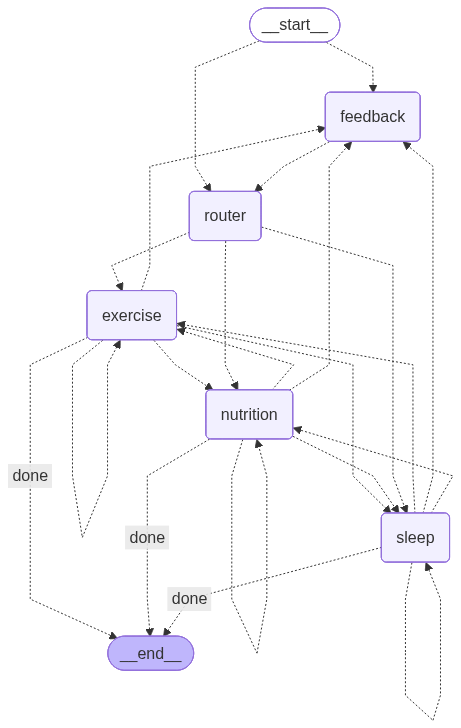

In [114]:
# Visualize the handoff graph
try:
    from IPython.display import display, Image
    display(Image(unified_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nGraph structure:")
    print(unified_graph.get_graph().draw_ascii())

In [ ]:

# Test the unified assistant - output to file for easier reading
import uuid
import sys
from io import StringIO
from datetime import datetime

# Create unique thread ID and output file with datetime
thread_id = uuid.uuid4()
config = {"configurable": {"thread_id": thread_id}}
user_id = "user_sarah"
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_file = f"test_results_{timestamp}.txt"

# Capture all print output
class TeeOutput:
    def __init__(self, file_path):
        self.file = open(file_path, 'w')
        self.stdout = sys.stdout
    def write(self, text):
        self.file.write(text)
        self.stdout.write(text)  # Also show minimal output in notebook
    def flush(self):
        self.file.flush()
        self.stdout.flush()
    def close(self):
        self.file.close()

# Redirect output to file
tee = TeeOutput(output_file)
sys.stdout = tee

print(f"Test Results - {timestamp}")
print(f"Thread ID: {thread_id}")
print(f"Output file: {output_file}")
print("="*60 + "\n")

print("=== INITIAL MEMORY STATE ===")
print_memory_report(store, user_id)

print("\n=== INVOKING GRAPH ===\n")
response = unified_graph.invoke(
    {
        "messages": [HumanMessage(content="can you give me an exercise, nutrition and sleep plan for the next 3 months?")],
        "user_id": "user_sarah",
        "feedback": "",
        "visited_agents": []
    },
    config
)

print("\n=== FINAL MEMORY STATE ===")
print_memory_report(store, user_id)

print("\n" + "="*60)
print("CONVERSATION HISTORY")
print("="*60)
for i, msg in enumerate(response['messages']):
    msg_type = type(msg).__name__.replace("Message", "")
    name = getattr(msg, 'name', None)
    label = f"{msg_type}" + (f" [{name}]" if name else "")
    print(f"\n[{i+1}] {label}:")
    print("-" * 40)
    # Full content in file (no truncation)
    print(msg.content)
print("\n" + "="*60)

# Restore stdout and close file
sys.stdout = tee.stdout
tee.close()

print(f"\n✅ Full output saved to: {output_file}")

Test Results - 2026-02-01_17-14-35
Thread ID: b06731b8-83f0-4532-a032-b2e0eb1a3e4b
Output file: test_results_2026-02-01_17-14-35.txt

=== INITIAL MEMORY STATE ===

MEMORY STATE REPORT
User Profile:
- name: {'value': 'Sarah'}
- goals: {'primary': 'improve sleep', 'secondary': 'reduce stress'}
- conditions: {'allergies': ['peanuts'], 'injuries': ['bad knee']}
Exercise_agent Instructions: You are an Exercise Specialist. Your job is to pro...be a complete, actionable exercise recommendation.
Nutrition_agent Instructions: You are a Nutrition Specialist. Your job is to pro...e a complete, actionable nutrition recommendation.
Sleep_agent Instructions: You are a Sleep Specialist. Your job is to provide...ld be a complete, actionable sleep recommendation.

--- Agent Episodes (Episodic Memory) ---
  exercise_agent: No episodes stored
  nutrition_agent: No episodes stored
  sleep_agent: No episodes stored
Namespace counts: {'profile': 3, 'preferences': 2, 'instructions': 0, 'episodes': 0}


=== I

In [ ]:
# Follow-up question (tests short-term memory)
# give feedback to the exercise agent - APPEND to same output file

# Append to the same output file
with open(output_file, 'a') as f:
    import sys
    old_stdout = sys.stdout
    sys.stdout = f
    
    print("\n\n" + "="*60)
    print("FOLLOW-UP #1: Feedback about shoulder concern")
    print("="*60 + "\n")
    
    response = unified_graph.invoke(
        {
            "messages": [HumanMessage(content="What exercise do you recomend to do first??")],
            "user_id": "user_sarah",
            "feedback": "that looks like it would hurt my shoulder... can you show me a different one that is easier on the shoulder?"
        },
        config  # Same thread
    )
    
    print("\n=== MEMORY STATE AFTER FEEDBACK ===")
    print_memory_report(store, user_id)
    
    print("\n" + "="*60)
    print("CONVERSATION HISTORY")
    print("="*60)
    for i, msg in enumerate(response['messages']):
        msg_type = type(msg).__name__.replace("Message", "")
        name = getattr(msg, 'name', None)
        label = f"{msg_type}" + (f" [{name}]" if name else "")
        print(f"\n[{i+1}] {label}:")
        print("-" * 40)
        print(msg.content)
    print("\n" + "="*60)
    
    sys.stdout = old_stdout

print(f"✅ Follow-up #1 appended to: {output_file}")

✅ Follow-up #1 appended to: test_results_2026-02-01_17-04-27.txt


In [ ]:
# Follow-up #2: Positive feedback - APPEND to same output file

with open(output_file, 'a') as f:
    import sys
    old_stdout = sys.stdout
    sys.stdout = f
    
    print("\n\n" + "="*60)
    print("FOLLOW-UP #2: Positive feedback")
    print("="*60 + "\n")
    
    response = unified_graph.invoke(
        {
            "messages": [HumanMessage(content="What exercise do you recomend to do first??")],
            "user_id": "user_sarah",
            "feedback": "that looks great!"
        },
        config  # Same thread
    )
    
    print("\n=== MEMORY STATE AFTER POSITIVE FEEDBACK ===")
    print_memory_report(store, user_id)
    
    print("\n" + "="*60)
    print("CONVERSATION HISTORY")
    print("="*60)
    for i, msg in enumerate(response['messages']):
        msg_type = type(msg).__name__.replace("Message", "")
        name = getattr(msg, 'name', None)
        label = f"{msg_type}" + (f" [{name}]" if name else "")
        print(f"\n[{i+1}] {label}:")
        print("-" * 40)
        print(msg.content)
    print("\n" + "="*60)
    
    sys.stdout = old_stdout

print(f"✅ Follow-up #2 appended to: {output_file}")

✅ Follow-up #2 appended to: test_results_2026-02-01_17-04-27.txt


### Advanced Build Implementation Notes
* I went a little TDD on this one, writing out the test cases first in order to make sure I would be able to understand the goal, and when things worked. This ensured I had the state machine fully understood.
* I tried to use langgraph here, but as mentioned the code has to be a python module, so I ported the code over to unified_agents.py:unifiedGraph to get this to work.

```
User Message
     ↓
create_handoff_node runs
     ↓
┌─────────────────────────────────────────────┐
│  build_memory_context() retrieves:          │
│  1. PROCEDURAL: Agent instructions (store)  │
│  2. LONG-TERM: User profile & preferences   │
│  3. SEMANTIC: Relevant wellness knowledge   │
│  4. EPISODIC: Similar past interactions     │
└─────────────────────────────────────────────┘
     ↓
summarize_conversation() (SHORT-TERM memory)
     ↓
Agent invoked with enriched context
     ↓
Handoff/routing logic
```
```
User: "What exercise?" + feedback: "shoulder concern"
                    ↓
              [ENTRY] Feedback detected!
                    ↓
              feedback node:
              1. Stores episode with feedback
              2. Updates agent instructions
                    ↓
              router → exercise → nutrition → sleep → done
```

* I added the current condition in the second response, a complaint about a shoulder injury, to the set of 'conditions' for the user.

* Adding streamlit was interesting, but pretty useful to see the state.  A JSON document is emitted and read by the streamlit process.  then when you hit 'Refresh' on streamlit you can see the latest conversation history.
```
┌─────────────────────┐
│   Run Notebook      │
│   (test cells)      │
└──────────┬──────────┘
           │
           ▼
┌─────────────────────┐
│ export_store_state()│ → memory_state.json
└──────────┬──────────┘
           │
           ▼
┌─────────────────────┐
│ streamlit run       │ ← reads memory_state.json
│ memory_dashboard.py │
└─────────────────────┘
```



In [ ]:
# ============================================================
# Export Store State for Streamlit Dashboard
# ============================================================
# Run this cell after your tests to export the memory state
# Then run: streamlit run memory_dashboard.py

export_store_state(store, "user_sarah")

✅ Store state exported to: memory_state.json
   Namespaces exported: 8
   To view in dashboard, run: streamlit run memory_dashboard.py


'memory_state.json'

---
## Summary

In this session, we explored the **5 memory types** from the CoALA framework:

| Memory Type | LangGraph Component | Scope | Wellness Use Case |
|-------------|---------------------|-------|-------------------|
| **Short-term** | `MemorySaver` + `thread_id` | Within thread | Current consultation |
| **Long-term** | `InMemoryStore` + namespaces | Across threads | User profile, goals |
| **Semantic** | Store + embeddings + `search()` | Across threads | Knowledge retrieval |
| **Episodic** | Store + few-shot examples | Across threads | Past successful interactions |
| **Procedural** | Store + self-reflection | Across threads | Self-improving instructions |

### Key Takeaways:

1. **Memory transforms chatbots into assistants** - Persistence enables personalization
2. **Different memory types serve different purposes** - Choose based on your use case
3. **Context management is critical** - Trim and summarize to stay within limits
4. **Episodic memory enables learning** - Show, don't just tell
5. **Procedural memory enables adaptation** - Agents can improve themselves

### Production Considerations:

- Use `PostgresSaver` instead of `MemorySaver` for persistent checkpoints
- Use `PostgresStore` instead of `InMemoryStore` for persistent long-term memory
- Consider TTL (Time-to-Live) policies for automatic memory cleanup
- Implement proper access controls for user data

### Further Reading:

- [LangGraph Memory Documentation](https://langchain-ai.github.io/langgraph/concepts/memory/)
- [CoALA Paper](https://arxiv.org/abs/2309.02427) - Cognitive Architectures for Language Agents
- [LangGraph Platform](https://docs.langchain.com/langgraph-platform/) - Managed infrastructure for production